<a href="https://colab.research.google.com/github/yasshf/MicroService/blob/main/aziz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime



df = pd.read_csv(r"/content/gestion_factures.csv", encoding='windows-1252')
df.head()


,numero_facture,montant,date_emission,date_echeance,statut
0,FCT-00001,5129.38,2023-04-29,2023-06-21,En attente
1,FCT-00002,6482.39,2024-10-30,2024-12-16,PayÃ©e
2,FCT-00003,7191.73,2022-10-16,2022-11-22,En attente
3,FCT-00004,9843.80,2024-07-15,2024-08-20,En attente
4,FCT-00005,1562.62,2024-10-13,2024-12-02,En retard


In [40]:
df.columns

Index(['numero_facture', 'montant', 'date_emission', 'date_echeance',
       'statut'],
      dtype='object')

In [41]:
# Check for missing values
print(df.isnull().sum())

numero_facture    0
montant           0
date_emission     0
date_echeance     0
statut            0
dtype: int64


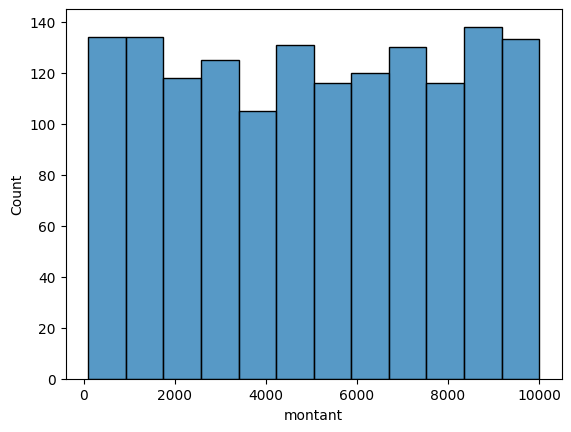

In [42]:
# Convert date columns to datetime
df['date_emission'] = pd.to_datetime(df['date_emission'])
df['date_echeance'] = pd.to_datetime(df['date_echeance'])

# Clean 'statut' column
df['statut'] = df['statut'].str.replace('Ã©', 'é')

# Remove rows where emission date is after due date (invalid data)
df = df[df['date_emission'] <= df['date_echeance']]

# Check montant distribution
sns.histplot(df['montant'])
plt.show()

# Remove negative amounts if any
df = df[df['montant'] > 0]

In [43]:
# Extract temporal features from emission date
df['emission_year'] = df['date_emission'].dt.year
df['emission_month'] = df['date_emission'].dt.month
df['emission_day'] = df['date_emission'].dt.day
df['emission_dayofweek'] = df['date_emission'].dt.dayofweek  # Monday=0, Sunday=6
df['emission_dayofyear'] = df['date_emission'].dt.dayofyear
df['emission_weekofyear'] = df['date_emission'].dt.isocalendar().week

# Create montant categories
df['montant_cat'] = pd.cut(df['montant'],
                          bins=[0, 1000, 5000, 10000, np.inf],
                          labels=['<1k', '1k-5k', '5k-10k', '>10k'])

# Optionally: Calculate and keep duration as an additional feature
df['duree_paiement'] = (df['date_echeance'] - df['date_emission']).dt.days

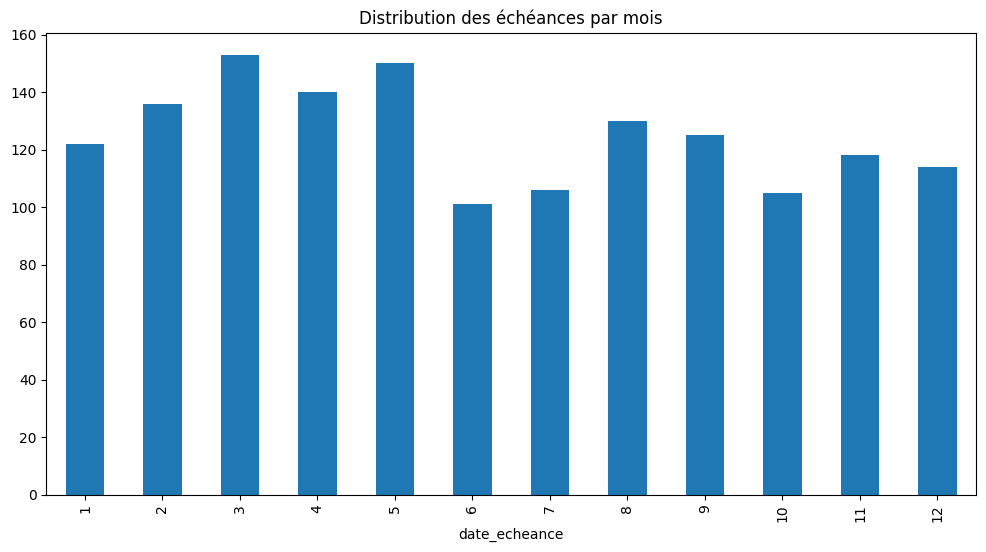

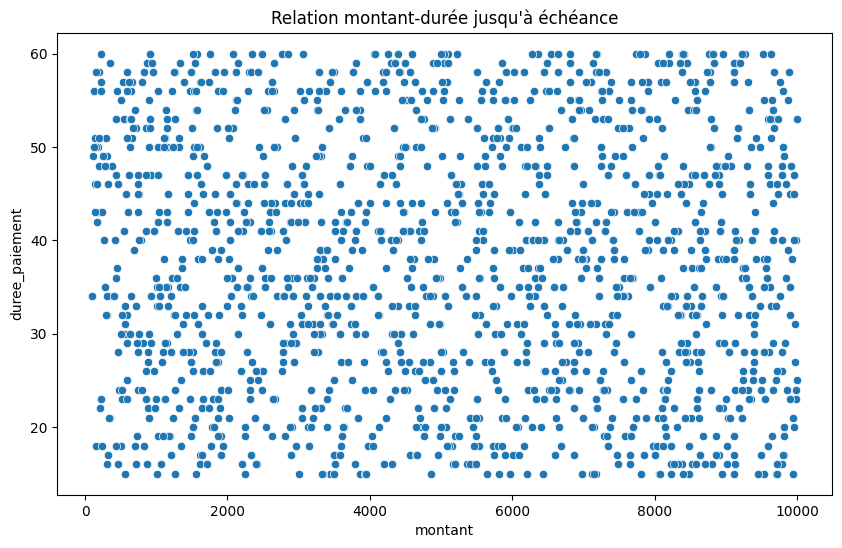

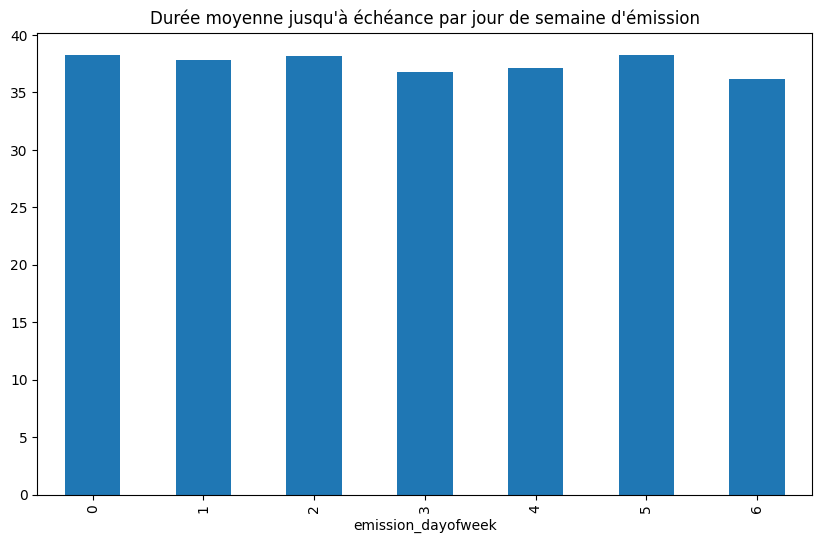

In [44]:
# Distribution of due dates by month
plt.figure(figsize=(12,6))
df['date_echeance'].dt.month.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution des échéances par mois')
plt.show()

# Relationship between amount and due date (via duration)
plt.figure(figsize=(10,6))
sns.scatterplot(x='montant', y='duree_paiement', data=df)
plt.title('Relation montant-durée jusqu\'à échéance')
plt.show()

# Average due date duration by day of week
plt.figure(figsize=(10,6))
df.groupby('emission_dayofweek')['duree_paiement'].mean().plot(kind='bar')
plt.title('Durée moyenne jusqu\'à échéance par jour de semaine d\'émission')
plt.show()

In [46]:
from sklearn.preprocessing import LabelEncoder

# Define your desired order
status_order = ['En attente', 'En retard', 'Payée']
le = LabelEncoder()
le.fit(status_order)  # Force the specific order

# Apply encoding
df['statut_encoded'] = le.transform(df['statut'])

# Check mapping
print("Encoding mapping:")
for i, class_name in enumerate(le.classes_):
    print(f"{class_name}: {i}")

Encoding mapping:
En attente: 0
En retard: 1
Payée: 2


In [47]:
# Clean status encoding
df['statut'] = df['statut'].str.replace('Ã©', 'é')
status_map = {'En attente':0, 'En retard':1, 'Payée':2}
df['statut_encoded'] = df['statut'].map(status_map)

# Invoice ID encoding
invoice_map = {v:i for i,v in enumerate(df['numero_facture'].unique())}
df['invoice_id'] = df['numero_facture'].map(invoice_map)

# Result
print(df[['numero_facture', 'invoice_id', 'statut', 'statut_encoded']].head())

  numero_facture  invoice_id      statut  statut_encoded
0      FCT-00001           0  En attente               0
1      FCT-00002           1       Payée               2
2      FCT-00003           2  En attente               0
3      FCT-00004           3  En attente               0
4      FCT-00005           4   En retard               1


In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# Convert dates to datetime
df['date_emission'] = pd.to_datetime(df['date_emission'])
df['date_echeance'] = pd.to_datetime(df['date_echeance'])

# Clean status column
df['statut'] = df['statut'].str.replace('Ã©', 'é')

# Feature engineering
df['emission_dayofweek'] = df['date_emission'].dt.dayofweek
df['emission_month'] = df['date_emission'].dt.month
df['emission_quarter'] = df['date_emission'].dt.quarter

# Convert target to ordinal (number of days since min date)
min_date = df['date_emission'].min()
df['target_ordinal'] = (df['date_echeance'] - min_date).dt.days

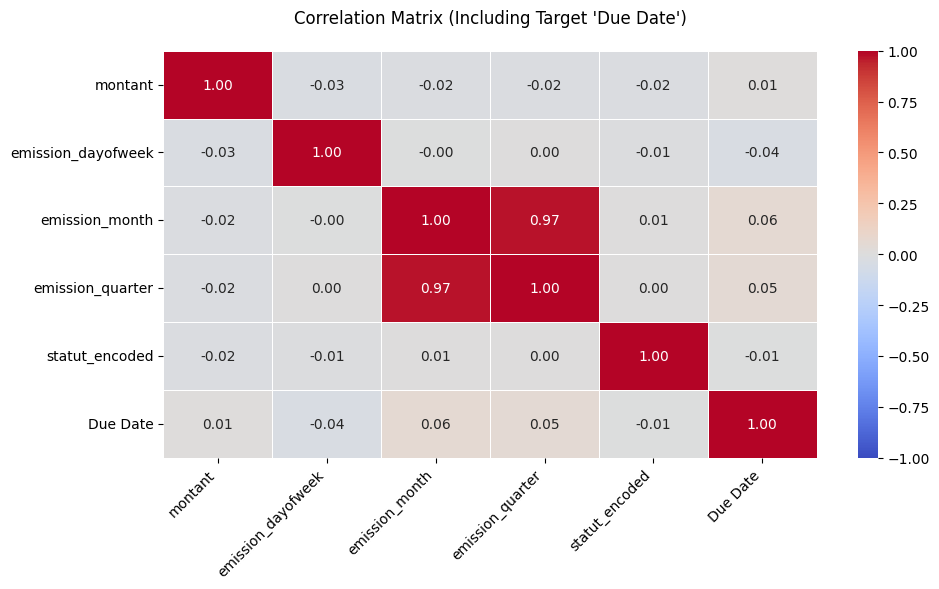

In [56]:
plt.figure(figsize=(10, 6))

# Select numerical features including the target
corr_features = ['montant', 'emission_dayofweek', 'emission_month',
                'emission_quarter', 'statut_encoded', 'target_ordinal']

# Create correlation matrix and rename target for clarity
corr_matrix = df[corr_features].corr().rename(columns={'target_ordinal': 'Due Date'},
                                            index={'target_ordinal': 'Due Date'})

# Plot heatmap
sns.heatmap(corr_matrix,
            annot=True,
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            linewidths=0.5,
            fmt=".2f")

plt.title("Correlation Matrix (Including Target 'Due Date')", pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Assuming df_model has the relevant features and target (y = 'days_to_due' column)
# Define features (X) and target (y)
X = df_model[['total_open_amount', 'posting_month', 'posting_year', 'posting_day']]
y = df_model['days_to_due']

# Handle missing values (if any)
imputer = SimpleImputer(strategy='mean')  # Impute missing values with mean
X_imputed = imputer.fit_transform(X)

# Scaling features (Standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [60]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Assuming you already have your dataframe 'df_model' ready and have defined X and y
# X = df_model[['total_open_amount', 'posting_month', 'posting_year', 'posting_day']]
# y = df_model['days_to_due']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models dictionary
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor(),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "SVM": SVR(kernel='rbf'),
    "Linear Regression": LinearRegression()
}

# Initialize a list to store the results
results = []

# Loop through models, train, and evaluate
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate regression metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # Manually calculate RMSE
    r2 = r2_score(y_test, y_pred)  # R² (accuracy for regression)

    # Append the results to the list
    model_metrics = {
        'Model': name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2  # R² as the accuracy measure
    }

    results.append(model_metrics)

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)

# Display the results
print("\nModel Evaluation Report:")
print(results_df)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 304
[LightGBM] [Info] Number of data points in the train set: 39853, number of used features: 4
[LightGBM] [Info] Start training from score -18150.939703

Model Evaluation Report:
               Model         MAE           MSE        RMSE        R2
0      Random Forest    0.000150      0.000106    0.010275  1.000000
1            XGBoost    0.078014      0.015104    0.122899  0.999999
2           LightGBM    0.132659      0.032483    0.180230  0.999998
3                KNN  130.974729  25046.451421  158.260707 -0.162389
4                SVM  127.318767  21559.547422  146.831698 -0.000564
5  Linear Regression    0.539771      0.424155    0.651272  0.999980
